<a href="https://colab.research.google.com/github/hasmeu/colab/blob/main/stateunion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.1 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasets import load_dataset
from collections import Counter

from datetime import datetime, timedelta

import nltk
from nltk.draw.dispersion import dispersion_plot

In [4]:
# Load the dataset
dataset = load_dataset("jsulz/state-of-the-union-addresses")

# Extract the necessary columns
dates = [item["date"] for item in dataset["train"]]
potus=[item["potus"] for item in dataset["train"]]
texts = [item["lemmatized"] for item in dataset["train"]]

# Combine dates, potus texts, then sort by dates
sorted_data = sorted(zip(dates, potus, texts), key=lambda x: x[0])
sorted_dates, sorted_potus,sorted_texts = zip(*sorted_data)




README.md:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

sotu.parquet:   0%|          | 0.00/20.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/245 [00:00<?, ? examples/s]

In [ ]:
sorted_dates[0:8]

(Timestamp('1790-01-08 00:00:00'),
 Timestamp('1790-12-08 00:00:00'),
 Timestamp('1791-10-25 00:00:00'),
 Timestamp('1792-11-06 00:00:00'),
 Timestamp('1793-12-03 00:00:00'),
 Timestamp('1794-11-19 00:00:00'),
 Timestamp('1795-12-08 00:00:00'),
 Timestamp('1796-12-07 00:00:00'))

In [5]:
import pandas as pd
from datetime import datetime, timedelta

# Assuming sorted_dates, sorted_potus, sorted_texts are defined

start_date = pd.Timestamp('1790-01-08')
block_size = timedelta(days=365 * 5)  # 5 years
current_date = start_date
blocks = []

current_block_texts = []
current_block_year = None

for date, potus, text in zip(sorted_dates, sorted_potus, sorted_texts):
    date = pd.Timestamp(date)
    if date >= current_date + block_size:
        # Start a new block
        if current_block_texts:
            blocks.append({
                "year": current_block_year,
                "text": current_block_texts
            })
        current_block_texts = []
        current_date += block_size
        current_block_year = date.year

    current_block_texts.extend(text)

# Append the last block
if current_block_texts:
    blocks.append({
        "year": current_block_year,
        "text": current_block_texts
    })

In [6]:
max_length = 0

for block in blocks:
    text_length = len(block["text"])
    if text_length > max_length:
        max_length = text_length

print(f"The length of the longest 'text' field is: {max_length}")

# Pad the blocks with "OOV" tokens
for block in blocks:
    padding_length = max_length - len(block["text"])
    block["text"].extend(["OOV"] * padding_length)

The length of the longest 'text' field is: 52162


In [13]:
years = [block["year"] for block in blocks]
all_texts = [block["text"] for block in blocks]
focus_words = ["liberty", "healthcare", "freedom", "duty", "war", "peace"]
# Customize with the words you want to focus on

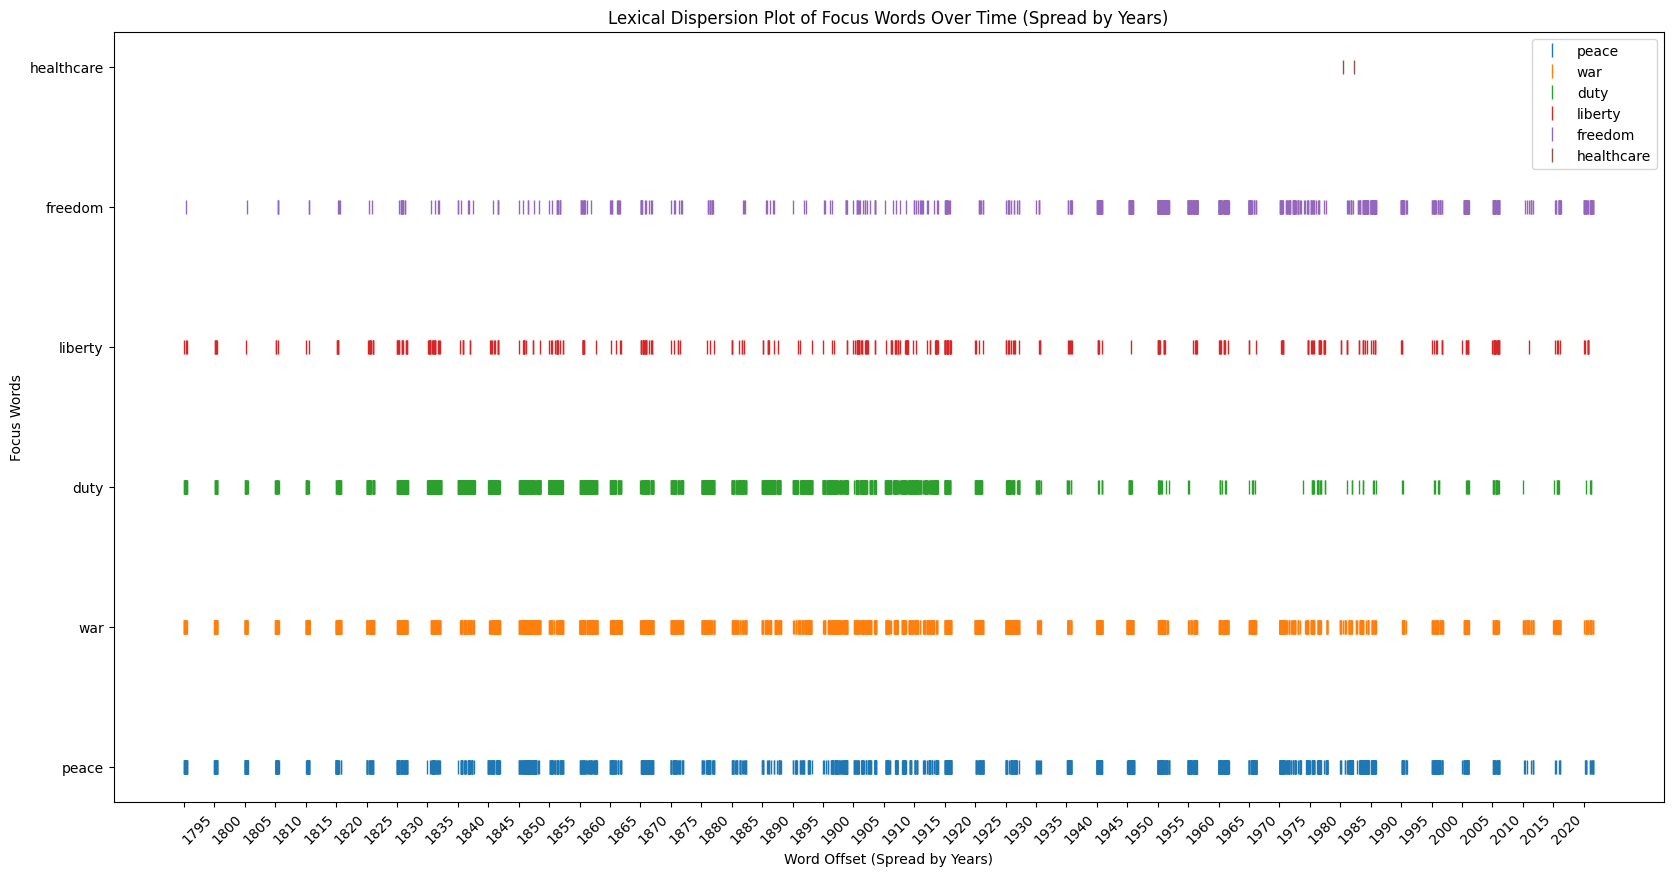

In [14]:
import nltk
from nltk.draw.dispersion import dispersion_plot
import matplotlib.pyplot as plt

# Assuming you have 'all_texts' and 'years' from your previous code

# Create a dictionary to store word offsets with year information
word_offsets_with_years = {}

offset = 0  # Initialize word offset
year_offsets = {}  # Store the starting offset of each year

for i, year_text in enumerate(all_texts):
    year = years[i]  # Get the year for the current text block
    year_offsets[year] = offset  # Store the starting offset for this year
    for word in year_text:
        if word in focus_words:
            word_offsets_with_years.setdefault(word, []).append(offset)
        offset += 1  # Increment the word offset

plt.figure(figsize=(20, 10))  # Adjust figure size as needed

for word, offsets in word_offsets_with_years.items():
    plt.plot(offsets, [word] * len(offsets), marker='|', linestyle='None', markersize=10, label=word)

# Add year labels to the x-axis
plt.xticks(list(year_offsets.values()), list(year_offsets.keys()), rotation=45, ha='right')

plt.xlabel("Word Offset (Spread by Years)")
plt.ylabel("Focus Words")
plt.title("Lexical Dispersion Plot of Focus Words Over Time (Spread by Years)")
plt.legend()
plt.show()